# Neural Style Transfer

## Import required libraries

In [1]:
import keras.backend as K
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing.image import load_img, img_to_array
from scipy.optimize import fmin_l_bfgs_b
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Set up files if used in a server

In [2]:
# !wget https://github.com/AparaV/artistic-style/raw/master/images/originals/river.jpg
# !wget https://github.com/AparaV/artistic-style/raw/master/images/originals/starry_night.jpg

In [3]:
# !mkdir img
# !mkdir output
# !mv *.jpg img/

In [4]:
!ls img

river.jpg  starry_night.jpg


In [5]:
cnt_img_path = 'img/river.jpg'
style_img_path = 'img/starry_night.jpg'
output_path = 'output/'

## Utilities

In [6]:
def imsave(img, path, target_size=(512, 512), postprocess=True):
    if postprocess:
        img = postprocess_array(img)
    img = Image.fromarray(img)
    img = img.resize(target_size)
    img.save(path)
    return img

def imread_tensor(path, target_size=(512,512)):
    '''
    reads an image and returns a preprocessed tensor
    '''
    img = load_img(path=path, target_size=target_size)
    img = img_to_array(img)
    img = K.variable(preprocess_input(np.expand_dims(img, axis=0)), dtype='float32')
    return img

def postprocess_array(x, target_size=(512, 512, 3)):
    if x.shape != target_size:
        x = x.reshape(target_size)
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    
    # BGR to RGB
    x = x[..., ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Implement Keras model

### Define important operations

In [7]:
def generate_canvas(mode='random', ref_image=None):
    '''
    Generate a canvas and return a placeholder
    Params:
    modes: random, from_ref
    ref_image: pass an img array or path if mode is 'from_ref'
    '''
    size = (512, 512, 3)

    if mode == 'random':
        img = np.random.randint(256, size=size)
    elif mode == 'from_ref':
        if type(ref_image) == str:
            img = load_img(path=ref_image, target_size=size)
            img = img_to_array(img)
        else:
            img = ref_image.copy()

    img = preprocess_input(np.expand_dims(img, axis=0))

    return img

In [8]:
def get_feature_maps(model, layers):
    '''
    Get feature maps for given layers in the required format
    '''
    features = []

    for layer in layers:
        feat = model.get_layer(layer).output
        shape = K.shape(feat).eval(session=tf_session)
        M = shape[1] * shape[2]
        N = shape[-1]
        feat = K.transpose(K.reshape(feat, (M, N)))
        features.append(feat)

    return features   

#### Content Loss

\begin{equation*}
L_{content}(\vec{p},\vec{x},\vec{l}) = 1 / 2 \sum (F^i_{ij} - P^i_{ij})^2
\end{equation*}


In [9]:
def content_loss(F, P):
    assert F.shape == P.shape
    loss = 0.5 * K.sum(K.square(F - P))
    return loss

#### Style Loss

Gram matrix:

\begin{equation*}
G^i_{ij} = \sum_k F^l_{ik} F^l_{jk}
\end{equation*}

In [10]:
def gram_matrix(matrix):
    return K.dot(matrix, K.transpose(matrix))

Contribution of each layer to style loss 

\begin{equation*}
E_l = \frac{1}{4 N^2_l M^2_l} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2
\end{equation*}

Total style loss

\begin{equation*}
L_{style}(\vec{a},\vec{x}) = \sum_{l=0}^l w_l E_l
\end{equation*}



In [11]:
def style_loss(G, A):
    '''
    Contribution of each layer to the total style loss
    '''
    assert G.shape == A.shape

    M, N = K.int_shape(G)[1], K.int_shape(G)[0]
    G, A = gram_matrix(G), gram_matrix(A)
    loss = 0.25 * K.sum(K.square(G - A)) / ((N ** 2) * (M ** 2))
    return loss

def total_style_loss(weights, Gs, As):
    '''
    Get weighted total style loss
    '''
    loss = K.variable(0)

    for w, G, A in zip(weights, Gs, As):
        loss = loss + w * style_loss(G, A)

    return loss    

#### The total loss function to be minimized

\begin{equation*}
L_{total}(\vec{p},\vec{a},\vec{x}) = \alpha L_{content}(\vec{p},\vec{x}) + \beta L_{style}(\vec{a},\vec{x})
\end{equation*}


In [12]:
def total_loss(P, As, canvas_model, clayers, slayers, style_weights, alpha=1.0, beta=10000.0):
    '''
    Get total loss
    Params:
    x: generated image
    p: content image features
    a: style image features
    '''
    F = get_feature_maps(canvas_model, clayers)[0]
    Gs = get_feature_maps(canvas_model, slayers)

    closs = content_loss(F, P)
    sloss = total_style_loss(style_weights, Gs, As)

    loss = alpha * closs + beta * sloss  
    return loss  

###  Read images and define model

Load all the images

In [13]:
target_size = (512, 512, 3)

In [14]:
cnt_img = imread_tensor(cnt_img_path)
style_img = imread_tensor(style_img_path)

Setup VGG model and required configuraton

In [15]:
canvas_placeholder = K.placeholder(shape=(1,)+target_size)

In [17]:
cnt_model = VGG16(include_top=False, weights='imagenet', input_tensor=cnt_img)
style_model = VGG16(include_top=False, weights='imagenet', input_tensor=style_img)
canvas_model = VGG16(include_top=False, weights='imagenet', input_tensor=canvas_placeholder)

In [18]:
tf_session = K.get_session()

In [19]:
cnt_layers = ['block4_conv2']
style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
]
Ws = [1.0 / float(len(style_layers))] * len(style_layers) # weights for each style layer

In [20]:
P = get_feature_maps(cnt_model, cnt_layers)[0]
As = get_feature_maps(style_model, style_layers)

X = generate_canvas('from_ref', cnt_img_path).flatten() # generate canvas from content

## Optimize the distance between content and style image

Define function to use with scipy optimizers. The total loss function is optimized using the **limited-memory BFGS** optimizer.

L-BFGS is a second order optimization method that works well compared to other popular methods when memory requirements can't be met.

In [21]:
epochs = 100
save_per_epoch = 10

In [22]:
# gimg - generated image in the canvas

step = 1

def calculate_loss(gimg):
    gimg = gimg.reshape((1,)+target_size)

    loss = total_loss(P, As, canvas_model, cnt_layers, style_layers, Ws)
    loss_func = K.function([canvas_model.input], [loss])
    return loss_func([gimg])[0].astype('float64')

def calculate_grad(gimg):
    gimg = gimg.reshape((1,)+target_size)

    loss = total_loss(P, As, canvas_model, cnt_layers, style_layers, Ws)
    gradients = K.gradients(loss, [canvas_model.input])
    grad_func = K.function([canvas_model.input], gradients)
    return grad_func([gimg])[0].flatten().astype('float64')

def callback(gimg):
    global step

    print(f'\rStep: {step}/{epochs}', end='')
    step += 1

    if (step % save_per_epoch) == 0 or (step == epochs):
        gimg = gimg.copy()
        path = output_path + f'out_{step}.jpg'
        imsave(gimg, path)

In [ ]:
X_optim, _, info = fmin_l_bfgs_b(calculate_loss, X, fprime=calculate_grad, maxiter=epochs, callback=callback)

## View the generated image

In [ ]:
path = output_path + 'optimal.jpg'
imsave(X_optim, path)

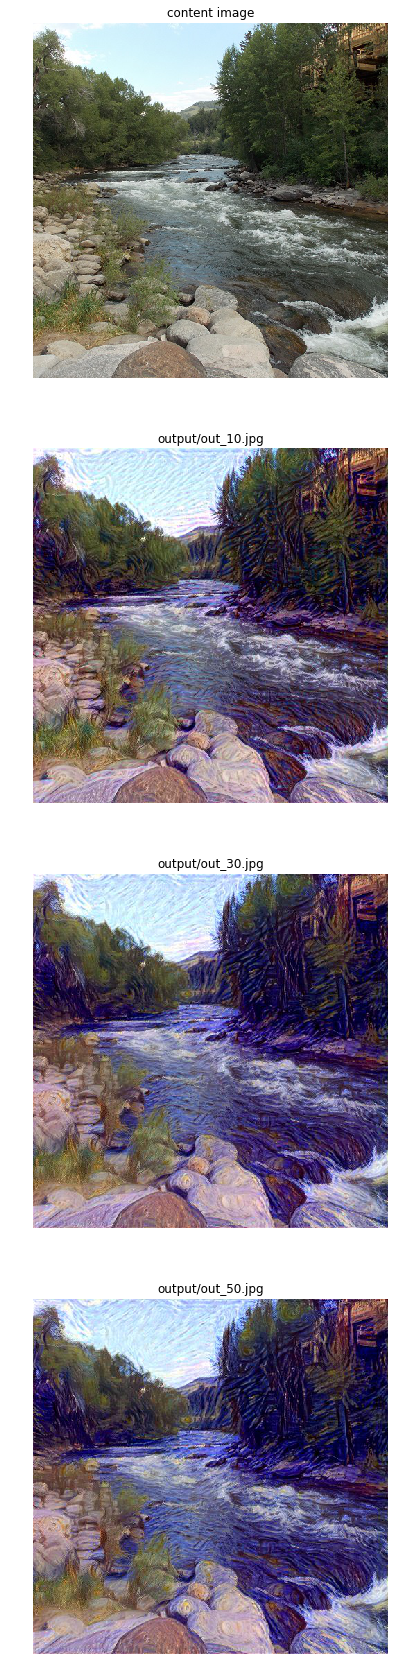

In [58]:
fig, axes = plt.subplots(4, 1, figsize=(20, 30))

names = [output_path+'out_'+str(i)+'.jpg' for i in [10,30,50]]

# original picture
img = Image.open(cnt_img_path)
img = np.array(img)
ax = axes[0]
ax.imshow(img)
ax.set_axis_off()
ax.set_title('content image')

for file, ax in zip(names, axes[1:]):
    img = Image.open(file)
    img = np.array(img)
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_title(file)

Comparison of images:

Text(0.5,1,'generated image')

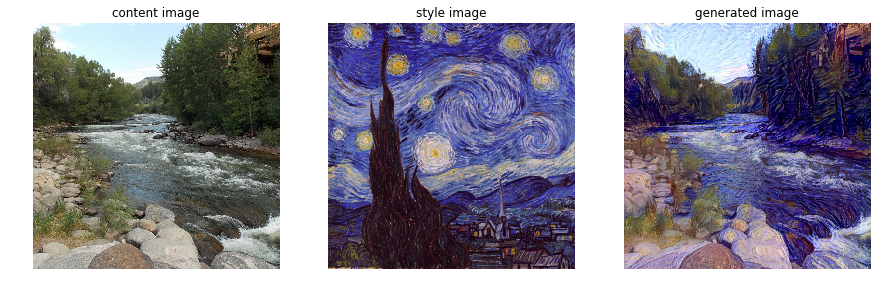

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

img = Image.open(cnt_img_path)
img = np.array(img)
ax = axes[0]
ax.imshow(img)
ax.set_axis_off()
ax.set_title('content image')

img = Image.open(style_img_path)
img = np.array(img)
ax = axes[1]
ax.imshow(img)
ax.set_axis_off()
ax.set_title('style image')

img = Image.open(output_path + 'out_50.jpg')
img = np.array(img)
ax = axes[2]
ax.imshow(img)
ax.set_axis_off()
ax.set_title('generated image')

## References

* [arXiv:1508.06576v2](https://arxiv.org/abs/1508.06576)
* [arXiv:1705.04058v6](https://arxiv.org/abs/1705.04058v6)
* https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216
* https://www.bonaccorso.eu/2016/11/13/neural-artistic-style-transfer-experiments-with-keras
